# Initializatoin

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# cd /content/drive/MyDrive/Colab\ Notebooks/Deep\ Learning\ Course/HW03

## Imports

In [3]:
import math
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.nn import Parameter

sys.path.append('/kaggle/input/dataset')
from name_dataset import Dataset

# RNN

## Traditional RNN

In the introductory section, we delve into the architecture of Recurrent Neural Networks (RNNs) and elucidate their training methodologies. To gain a deeper understanding of RNNs, you're encouraged to explore further [HERE](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-network)

For the task at hand, you've been furnished with the Names dataset, a compilation comprising thousands of surnames from 18 distinct languages of origin. Your objective is to prognosticate the language of origin for a given name, relying solely on its orthography. Your task primarily involves implementing the section demarcated by `#your_code`.

In [4]:
dataset = Dataset()
for i in range(10):
    category, line, _, _ = dataset.randomTrainingExample()
    print('category =', category, '- random name =', line)

Error occurred while downloading data.zip: --2024-04-30 09:34:48--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.35.166.68, 13.35.166.127, 13.35.166.45, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.166.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: 'data.zip'

     0K .......... .......... .......... .......... ..........  1%  254K 11s
    50K .......... .......... .......... .......... ..........  3%  256K 11s
   100K .......... .......... .......... .......... ..........  5%  255K 10s
   150K .......... .......... .......... .......... ..........  7% 66.4M 8s
   200K .......... .......... .......... .......... ..........  8% 75.1M 6s
   250K .......... .......... .......... .......... .......... 10%  300K 6s
   300K .......... .......... .......... .......... .......... 12% 1.57M 6s
   350K .......... .......... .......... ....

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        
        hidden = self.i2h(combined)
        
        output = self.h2o(hidden)
        output = self.softmax(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_letters = len(string.ascii_letters + " .,;'")
n_categories = 18

rnn = RNN(n_letters, n_hidden, n_categories)


In [6]:
import torch
import torch.nn as nn

criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, name_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

And here you can train your model and see it's performance after each 5000 iterations

15000 4% 0.4365 Lihovskih is predicted as a "Russian" name, status = ✓
30000 9% 0.9648 Mo is predicted as a "Korean" name, status = ✓
45000 13% 0.2326 Naomhan is predicted as a "Irish" name, status = ✓
60000 18% 2.4126 Johnstone is predicted as a "English" name, status = ✗ (Scottish)
75000 22% 1.5207 Cracchiolo is predicted as a "Spanish" name, status = ✗ (Italian)
90000 27% 0.7491 Fakhoury is predicted as a "Arabic" name, status = ✓
105000 31% 1.6987 Kaglantge is predicted as a "French" name, status = ✗ (Greek)
120000 36% 0.4830 Harb is predicted as a "Arabic" name, status = ✓
135000 40% 3.2515 Silhan is predicted as a "Irish" name, status = ✗ (Czech)
150000 45% 0.6128 Rios is predicted as a "Portuguese" name, status = ✓
165000 50% 1.2693 O'Bree is predicted as a "Portuguese" name, status = ✗ (Irish)
180000 54% 1.5555 Kieu is predicted as a "Chinese" name, status = ✗ (Vietnamese)
195000 59% 0.0097 Kwang  is predicted as a "Korean" name, status = ✓
210000 63% 2.9579 Levesque is predict

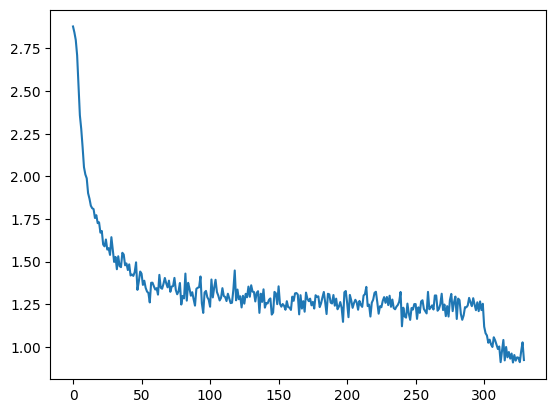

In [7]:
n_iters = 330_000
print_every = 15000

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = dataset.randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, _ = dataset.categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f %s is predicted as a "%s" name, status = %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    if iter % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0
        
    if iter == 300000:
        print("-" * 100)
        learning_rate = 0.001
        print_every = 1500

plt.figure()
plt.plot(all_losses)

In [8]:
n_iters = 20
print_every = 1

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = dataset.randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)

    if iter % print_every == 0:
        guess, _ = dataset.categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f %s is predicted as a "%s" name, status = %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

1 5% 0.0410 Rameckers is predicted as a "Dutch" name, status = ✓
2 10% 3.6648 Raval is predicted as a "Spanish" name, status = ✗ (English)
3 15% 0.7361 Egger is predicted as a "German" name, status = ✓
4 20% 2.5774 Wyman is predicted as a "Scottish" name, status = ✗ (German)
5 25% 0.2081 Crespo is predicted as a "Portuguese" name, status = ✓
6 30% 0.0453 Tsumura is predicted as a "Japanese" name, status = ✓
7 35% 0.1309 Trinh is predicted as a "Vietnamese" name, status = ✓
8 40% 0.0532 Son is predicted as a "Korean" name, status = ✓
9 45% 0.7681 Hummel is predicted as a "German" name, status = ✓
10 50% 1.0805 Moreno is predicted as a "Portuguese" name, status = ✓
11 55% 0.1231 Gniewek is predicted as a "Polish" name, status = ✓
12 60% 3.8139 Reyes is predicted as a "French" name, status = ✗ (Spanish)
13 65% 1.5862 Monette is predicted as a "English" name, status = ✗ (French)
14 70% 2.9363 Martin is predicted as a "French" name, status = ✗ (Scottish)
15 75% 0.7432 Sung is predicted as a

## Traditional RNN Disadvantages

In this part, we aim to delve into the limitations of traditional RNNs:
1.   Recurrent computation is slow
2.   They have difficulty accessing information from many steps back.

You are provided with a simple code that helps you to give the idea better. By modifying this code, you are able to demonstrate the mentioned disadvantages, but you are also free to change the code if needed or use any dataset you want.

**Question:** Do you think using GPU instead of CPU completely solves the first problem?

نه چون اصلا قابل موازی سازی نیست پس قرار نیست با GPU بهتر عمل کند یا سرعتش خیلی بهبود بخشد.

Note: The main goal of this part is to help you understand these problems better. Don't be too hard to implement and delivery.

Epoch [10/100], Loss: 1.1375
Epoch [20/100], Loss: 1.0540
Epoch [30/100], Loss: 0.9763
Epoch [40/100], Loss: 0.9006
Epoch [50/100], Loss: 0.8228
Epoch [60/100], Loss: 0.7389
Epoch [70/100], Loss: 0.6445
Epoch [80/100], Loss: 0.5363
Epoch [90/100], Loss: 0.4173
Epoch [100/100], Loss: 0.3019


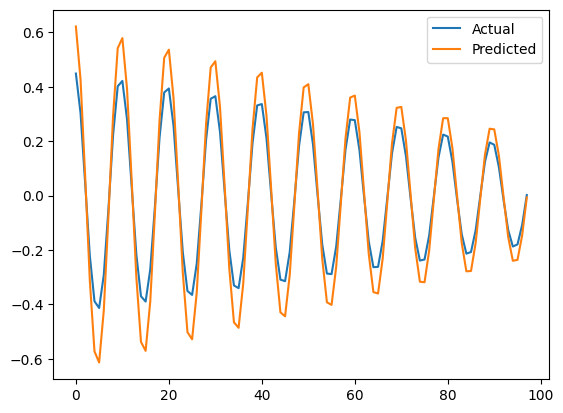

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate sinusoidal temperature data with decreasing range over time
np.random.seed(0)
num_periods = 50
timesteps_per_period = 10
total_timesteps = num_periods * timesteps_per_period

# Generate decreasing factor
decreasing_factor = np.linspace(1, 0.1, total_timesteps)

# Generate temperature data with decreasing sinusoidal range
temperature_data = np.sin(np.linspace(0, 2*np.pi*num_periods, total_timesteps)) * decreasing_factor

# Normalize the data
temperature_data = (temperature_data - np.mean(temperature_data)) / np.std(temperature_data)

# Convert numpy array to PyTorch tensor
temperature_data = torch.tensor(temperature_data, dtype=torch.float32).view(-1, 1)

# Define function to create dataset with sinusoidal pattern
def create_dataset(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        seq_in = data[i:i+seq_length]
        seq_out = data[i+seq_length]
        X.append(seq_in)
        Y.append(seq_out)
    return torch.stack(X), torch.stack(Y)

# Define sequence length and create dataset
sequence_length = 10  # Number of previous days to look at for prediction
X, Y = create_dataset(temperature_data, sequence_length)

# Split the dataset into train and test sets
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = 1
hidden_size = 10
output_size = 1

# Instantiate the model
model = SimpleRNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

# Plot actual vs predicted
plt.plot(test_predictions.numpy(), label='Actual')
plt.plot(Y_test.numpy(), label='Predicted')
plt.legend()
plt.show()

# LSTM Preparation

Now that you have experience with traditional RNNs, it's time to implement the LSTM model. Your goal is to implement the cell and model for LSTM architecture. The proposed dataset for this section is MNIST, allowing you to focus solely on model implementation.

In [10]:
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.ToTensor())

batch_size = 128
n_iters = 6000
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:01<00:00, 6058063.93it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 160629.72it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:50<00:00, 32447.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 2993013.16it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [11]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## LSTM Cells

In [12]:
from torch.autograd import Variable
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))
            hx = (hx, hx)

        h, c = hx

        gates = self.xh(input) + self.hh(h)
        gates = gates.squeeze()
        
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)
        i_t = torch.sigmoid(input_gate)
        f_t = torch.sigmoid(forget_gate)
        g_t = torch.tanh(cell_gate)
        o_t = torch.sigmoid(output_gate)

        cy = (f_t * c) + (i_t * g_t)  
        hy = o_t * torch.tanh(cy) 

        return (hy, cy)


## LSTM Models

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        return out

In [14]:
import torch.optim as optim
input_dim = 28
hidden_dim = 128
layer_dim = 1  # ONLY 1 OR 2
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
def train_and_evaluate(model, trainloader, testloader, criterion, optimizer, num_iterations=3000, eval_every=500):
    model.train()
    total_step = len(trainloader)
    iter_count = 0

    for epoch in range(num_iterations // total_step):
        for i, (images, labels) in enumerate(trainloader):
            images = images.view(-1, 28, 28).to(device) 
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            iter_count += 1
            if iter_count % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    correct = 0
                    total = 0
                    for images, labels in testloader:
                        images = images.view(-1, 28, 28).to(device)
                        labels = labels.to(device)
                        outputs = model(images)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                print(f'Iteration {iter_count}, Loss: {loss.item()}, Accuracy: {accuracy}%')
                model.train()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer)

Iteration 500, Loss: 0.2796328365802765, Accuracy: 94.14%
Iteration 1000, Loss: 0.11713200807571411, Accuracy: 96.08%
Iteration 1500, Loss: 0.10878629237413406, Accuracy: 96.85%
Iteration 2000, Loss: 0.15221230685710907, Accuracy: 97.39%
Iteration 2500, Loss: 0.09443838894367218, Accuracy: 97.57%


# Sentiment Analysis

Now you are ready to face a real-world problem. In this task, we want you to do a sentiment analysis on the [IMDB dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). The main goal is to reach more than an acceptable accuracy of **75%** on LSTM model. You are free to use torch.nn.LSTM to design your architecture, but you must prepare the IMDB dataset on your own.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer

In [40]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
X = df['review']
y = df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

def pad_truncate_sequences(sequences, maxlen):
    sequences = [seq[:maxlen] for seq in sequences]
    return pad_sequence([torch.tensor(seq) for seq in sequences], batch_first=True, padding_value=0)

max_review_length = 250
X_train_pad = pad_truncate_sequences(X_train_seq, max_review_length)
X_test_pad = pad_truncate_sequences(X_test_seq, max_review_length)

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

class ReviewDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.reviews[idx], self.labels[idx]

train_dataset = ReviewDataset(X_train_pad, y_train)
test_dataset = ReviewDataset(X_test_pad, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [46]:
class SentimentModel(nn.Module):
    def __init__(self):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=2000, embedding_dim=32)
        self.dropout = nn.Dropout(0.2)
        self.lstm = nn.LSTM(input_size=32, hidden_size=32, batch_first=True)
        self.fc1 = nn.Linear(32, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x, _ = self.lstm(x)
        x = self.fc1(x[:, -1, :])
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = SentimentModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    model.train()
    train_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        for texts, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for texts, labels in test_loader:
                outputs = model(texts)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()
            val_loss /= len(test_loader)
        
        train_losses.append(train_loss)
        validation_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        model.train()
    return train_losses, validation_losses

In [47]:
train_losses, validation_losses = train_model(model, train_loader, test_loader, criterion, optimizer, 20)

Epoch 1/20, Train Loss: 0.6936, Validation Loss: 0.6935
Epoch 2/20, Train Loss: 0.6898, Validation Loss: 0.6835
Epoch 3/20, Train Loss: 0.6895, Validation Loss: 0.6938
Epoch 4/20, Train Loss: 0.6832, Validation Loss: 0.6857
Epoch 5/20, Train Loss: 0.6751, Validation Loss: 0.6855
Epoch 6/20, Train Loss: 0.5487, Validation Loss: 0.3877
Epoch 7/20, Train Loss: 0.3742, Validation Loss: 0.3214
Epoch 8/20, Train Loss: 0.3280, Validation Loss: 0.3147
Epoch 9/20, Train Loss: 0.3022, Validation Loss: 0.2853
Epoch 10/20, Train Loss: 0.2877, Validation Loss: 0.2825
Epoch 11/20, Train Loss: 0.2749, Validation Loss: 0.2727
Epoch 12/20, Train Loss: 0.2634, Validation Loss: 0.2679
Epoch 13/20, Train Loss: 0.2587, Validation Loss: 0.2689
Epoch 14/20, Train Loss: 0.2508, Validation Loss: 0.2777
Epoch 15/20, Train Loss: 0.2417, Validation Loss: 0.2743
Epoch 16/20, Train Loss: 0.2371, Validation Loss: 0.2676
Epoch 17/20, Train Loss: 0.2327, Validation Loss: 0.2669
Epoch 18/20, Train Loss: 0.2240, Validat

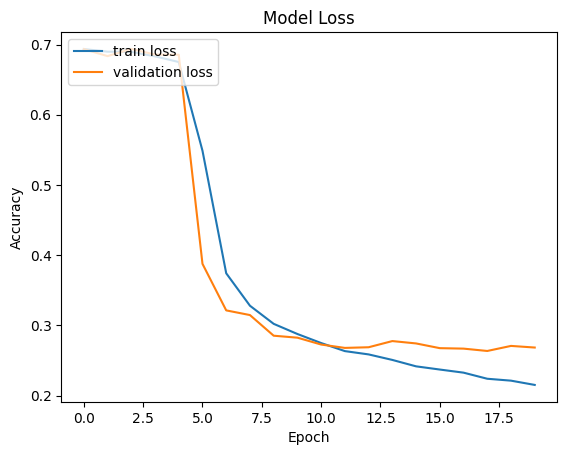

In [49]:
plt.plot(train_losses, label='train loss')
plt.plot(validation_losses, label='validation loss')
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [21]:
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=1)

print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8857 - loss: 0.3049
Test Accuracy: 0.8858000040054321
Test Loss: 0.31005141139030457
